# Regional Model Evaluation
This notebook assembles a prediction df from assorted feature prediction files (saved by CLSTM_EDA_TRAIN_MODELS.ipynb)

In [1]:
# !pip3 install pickle5
# !pip install tqdm
import tqdm
import pickle5 as pickle
import matplotlib as mpl
import pandas as pd
import numpy as np
import math
import tensorflow as tf

from matplotlib import pyplot

from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPooling3D
from numpy import zeros, newaxis

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import f1_score
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression


import seaborn as sns
import pylab as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

import io
from PIL import Image
from io import StringIO


import time
from tqdm import tqdm
from time import sleep

from IPython.display import clear_output

from sklearn.metrics import mean_absolute_percentage_error

pd.options.mode.chained_assignment = None  # default='warn'

start_time = time.time()

# Set run variables here

In [2]:


multi_features = 1
# use_mask_for_testing = 0
#how many months to offset selected columns
offset = 0
#region to leave unmasked
region = 2
train_size = 140
model_names = [ 'base_model', 'ca_model', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9', 'model_10']



# Resize SCA image to 256x256 to avoid Out-of-Memory issues.
img_height = 128
img_width = 128
IMAGE_SHAPE = (1, 128,128, 4)

In [3]:
region_mask = pd.read_csv('data/Region_mask.csv').to_numpy()
flat_mask = region_mask.flatten().tolist()
region_list = range(1,11)

In [4]:
path = './data/all_data_with_catdef_masks.pkl'
with open(path, "rb") as fh:
  data = pickle.load(fh)
# all_data_df = pd.read_pickle('./data/all_data.pkl')
# now_with_predictions = data.copy()
all_data_df = data.copy(deep=True)
test_months = np.arange(train_size, len(all_data_df), 1)
#reindex Month column for clarity
all_data_df['Month'] =  np.arange(0, len(all_data_df), 1)
all_data_df = all_data_df.rename(columns={"Month": "Data_month"})
all_data_df.iloc[:,:20].tail(5)

,Year,Data_month,SCA,Landsat_Image,BW_SCA_Image,Color_SCA_Image,CA_catdef,catdef,catdef_region_1,catdef_region_2,catdef_region_3,catdef_region_4,catdef_region_5,catdef_region_6,catdef_region_7,catdef_region_8,catdef_region_9,catdef_region_10,rzexc,evap
163,2016,163,17512327,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 285.88, 333.63, 336.38, 361.8...","[[nan, nan, nan, 285.88, 333.63, 336.38, 361.8...","[[nan, nan, nan, 285.88, 333.63, 336.38, 361.8...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, -3.9957, -3.1636, -2.1148, -2...","[[nan, nan, nan, 2.2829, 1.8117, 1.4501, 1.449..."
164,2016,164,5087669,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 331.28, 365.91, 358.28, 384.0...","[[nan, nan, nan, 331.28, 365.91, 358.28, 384.0...","[[nan, nan, nan, 331.28, 365.91, 358.28, 384.0...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, -1.5957, -0.9429, -0.66165, -...","[[nan, nan, nan, 1.3406, 1.0467, 0.8836, 0.825..."
165,2016,165,594940,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 223.11, 249.48, 257.23, 310.7...","[[nan, nan, nan, 223.11, 249.48, 257.23, 310.7...","[[nan, nan, nan, 223.11, 249.48, 257.23, 310.7...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, 9.1253, 9.3519, 8.0082, 6.578...","[[nan, nan, nan, 2.1658, 2.1365, 1.7502, 1.607..."
166,2016,166,51564,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 63.858999999999995, 106.34, 1...","[[nan, nan, nan, 63.858999999999995, 106.34, 1...","[[nan, nan, nan, 63.858999999999995, 106.34, 1...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, 3.6924, 4.0215, 3.4236, 3.188...","[[nan, nan, nan, 2.7493, 2.1238, 1.3541, 1.169..."
167,2016,167,40088,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA s

# Functions

In [5]:
# this applies the region mask to a flat list
def mask_list(full_list, mask, region):
    if len(full_list) == 1:
        full_list = full_list[0]
    masked_list = np.array(full_list.copy())
    for i in range(len(full_list)):
        if region == 9999:
            if mask[i] > 0:
                 masked_list[i] = full_list[i]
            else:
                masked_list[i] = None
        else:        
            if mask[i] == region:
                masked_list[i] = full_list[i]
            else:
                masked_list[i] = None 
    return masked_list

# Compile model predictions
Assemble prediction df from assorted feature prediction files (saved by CLSTM_EDA_TRAIN_MODELS.ipynb)

In [6]:
feature_list = ['rzmc', 'RainfC', 'srfexc', 'evap']


In [7]:
model_cols = []
pred_cols = []
compiled_models0 = pd.DataFrame()
import_path = str('./2_input_data/all_predictions_' + str(feature_list[0]) + '.pkl')
with open(import_path, "rb") as fh:
    compiled_models0 = pickle.load(fh)
    compiled_models0 = pd.DataFrame(compiled_models0['Month'])

for feature in feature_list:
    import_path = str('./2_input_data/all_predictions_' + str(feature) + '.pkl')
    with open(import_path, "rb") as fh:
        temp_df = pickle.load(fh)
    compiled_models0[str(str(feature) + '_model')] = temp_df['Model']
    model_cols.append(str(str(feature) + '_model'))
    compiled_models0[str(str(feature) + '_prediction')] = temp_df['y_prediction']
    pred_cols.append(str(str(feature) + '_prediction'))

compiled_models0

,Month,rzmc_model,rzmc_prediction,RainfC_model,RainfC_prediction,srfexc_model,srfexc_prediction,evap_model,evap_prediction
0,123,base_model_rzmc,"[-1.2222873, -3.0302892, -1.081477, 80.523056,...",base_model_RainfC,"[2.6313698, 0.41700366, 1.6059939, 82.595535, ...",base_model_srfexc,"[-0.2130812, -0.89183533, -0.64366615, 158.655...",base_model_evap,"[3.862039, -3.3022914, 1.1359739, 94.85064, 12..."
1,124,base_model_rzmc,"[-1.6070445, -3.0670495, -0.72268397, 111.4295...",base_model_RainfC,"[1.90893, -0.48643717, 2.6777809, 119.987465, ...",base_model_srfexc,"[-0.086760126, -1.6711498, -0.6581434, 157.703...",base_model_evap,"[3.514492, -3.7944584, 1.6374869, 104.68668, 1..."
2,125,base_model_rzmc,"[-1.8769262, -3.708483, -0.71965677, 131.65462...",base_model_RainfC,"[1.4152868, -0.05595991, 3.401934, 114.634895,...",base_model_srfexc,"[-0.6458922, -1.6667751, -0.37399888, 182.3487...",base_model_evap,"[3.5580626, -3.9784856, 2.0558534, 127.942924,..."
3,126,base_model_rzmc,"[-2.0967476, -4.0359263, -1.5123141, 181.1222,...",base_model_RainfC,"[1.0843471, 1.3497522, 2.4392116, 175.7811, 22...",base_model_srfexc,"[-1.4464928, -1.3728138, -0.09691501, 200.5179...",base_model_evap,"[4.3205433, -4.260375, 2.2176697, 186.0635, 23..."
4,127,base_model_rzmc,"[-1.425067, -3.801205, -2.0726473, 254.75966, ...",base_model_RainfC,"[0.88303393, 1.7320554, 2.8011951, 226.1223, 2...",base_model_srfexc,"[-2.0114865, -2.4326768, -0.09367132, 254.2419...",base_model_evap,"[5.376707, -4.8499217, 2.6120586, 256.22867, 3..."
...,...,...,...,...,...,...,...,...,...
490,163,model_10_rzmc,"[-0.39969566, 0.98505217, 0.3276039, 0.3617718...",model_10_RainfC,"[0.2833901, -0.10634768, -0.29937345, 0.608095...",model_10_srfexc,"[-0.22448778, 0.49123314, 0.063914604, 0.22641...",model_10_evap,"[0.061682865, 0.1175009, 0.04855023, -0.001473..."
491,164,model_10_rzmc,"[-0.36407605, 1.0550857, 0.32270944, 0.3937523...",model_10_RainfC,"[0.41365135, -0.07041353, -0.40528294, 0.66743...",model_10_srfexc,"[-0.2096948, 0.5255808, 0.058416434, 0.2192949...",model_10_evap,"[0.14317818, 0.062075227, 0.075431965, 0.04008..."
492,165,model_10_rzmc,"[-0.23649503, 0.8922244, 0.4119663, 0.29251805...",model_10_RainfC,"[0.41421205, -0.20218071, -0.35916993, 0.72413...",model_10_srfexc,"[-0.1953678, 0.48413718, 0.1193356, 0.28238738...",model_10_evap,"[0.20396121, 0.041110396, 0.06409045, 0.011932..."
493,166,model_10_rzmc,"[-0.24109277, 0.75392085, 0.47950178, 0.224909...",model_10_RainfC,"[0.37693197, -0.31114906, -0.22933352, 0.67222...",model_10_srfexc,"[-0.18587056, 0.47412974, 0.087706275, 0.25397...",model_10_evap,"[0.22053994, 0.12580007, 0.02049618, 0.0222972..."


In [8]:
# tall_month_col = []
mnth = compiled_models0['Month'].tolist()

tall_df = pd.DataFrame()
# tall_df['Month'] = pd.Series(mnth).repeat(4)
tall_df['Month'] = mnth * 4
tall_df.reset_index(drop=True, inplace=True)

tall_mod_col = []
for i in model_cols:
    tall_mod_col.extend(compiled_models0[i].tolist())
tall_df['Model'] = tall_mod_col
                   
tall_pred_col = []
for i in pred_cols:
    tall_pred_col.extend(compiled_models0[i].tolist())
tall_df['Pred'] =  tall_pred_col
# compiled_models[i].tolist()
tall_df

,Month,Model,Pred
0,123,base_model_rzmc,"[-1.2222873, -3.0302892, -1.081477, 80.523056,..."
1,124,base_model_rzmc,"[-1.6070445, -3.0670495, -0.72268397, 111.4295..."
2,125,base_model_rzmc,"[-1.8769262, -3.708483, -0.71965677, 131.65462..."
3,126,base_model_rzmc,"[-2.0967476, -4.0359263, -1.5123141, 181.1222,..."
4,127,base_model_rzmc,"[-1.425067, -3.801205, -2.0726473, 254.75966, ..."
...,...,...,...
1975,163,model_10_evap,"[0.061682865, 0.1175009, 0.04855023, -0.001473..."
1976,164,model_10_evap,"[0.14317818, 0.062075227, 0.075431965, 0.04008..."
1977,165,model_10_evap,"[0.20396121, 0.041110396, 0.06409045, 0.011932..."
1978,166,model_10_evap,"[0.22053994, 0.12580007, 0.02049618, 0.0222972..."


In [9]:
#### save compiled pred to .pkl

compile_predictions = 1
if compile_predictions == 1:
    pred_savestr = str('vert_compiled_predictions.pkl')
    path = str('./2_input_data/' + pred_savestr)
    with open(path, "wb") as fh:
      pickle.dump(tall_df, fh)

In [10]:
compiled_models = tall_df
compiled_models

,Month,Model,Pred
0,123,base_model_rzmc,"[-1.2222873, -3.0302892, -1.081477, 80.523056,..."
1,124,base_model_rzmc,"[-1.6070445, -3.0670495, -0.72268397, 111.4295..."
2,125,base_model_rzmc,"[-1.8769262, -3.708483, -0.71965677, 131.65462..."
3,126,base_model_rzmc,"[-2.0967476, -4.0359263, -1.5123141, 181.1222,..."
4,127,base_model_rzmc,"[-1.425067, -3.801205, -2.0726473, 254.75966, ..."
...,...,...,...
1975,163,model_10_evap,"[0.061682865, 0.1175009, 0.04855023, -0.001473..."
1976,164,model_10_evap,"[0.14317818, 0.062075227, 0.075431965, 0.04008..."
1977,165,model_10_evap,"[0.20396121, 0.041110396, 0.06409045, 0.011932..."
1978,166,model_10_evap,"[0.22053994, 0.12580007, 0.02049618, 0.0222972..."


In [11]:
# split predictions into regions
compiled_reg_split = compiled_models.copy()
for region in range(1,11):
    col_str = str('Pred' + '_r' + str(region))
    # compiled_reg_split[col_str] = compiled_reg_split[col_str]
    compiled_reg_split[col_str] = compiled_models['Pred'].apply(lambda x: mask_list(x, flat_mask, region))
compiled_reg_split

,Month,Model,Pred,Pred_r1,Pred_r2,Pred_r3,Pred_r4,Pred_r5,Pred_r6,Pred_r7,Pred_r8,Pred_r9,Pred_r10
0,123,base_model_rzmc,"[-1.2222873, -3.0302892, -1.081477, 80.523056,...","[nan, nan, nan, 80.523056, 97.14848, 107.28339...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,124,base_model_rzmc,"[-1.6070445, -3.0670495, -0.72268397, 111.4295...","[nan, nan, nan, 111.42951, 138.04276, 150.2913...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,125,base_model_rzmc,"[-1.8769262, -3.708483, -0.71965677, 131.65462...","[nan, nan, nan, 131.65462, 166.59041, 180.7269...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,126,base_model_rzmc,"[-2.0967476, -4.0359263, -1.5123141, 181.1222,...","[nan, nan, nan, 181.1222, 220.9216, 228.90634,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,127,base_model_rzmc,"[-1.425067, -3.801205, -2.0726473, 254.75966, ...","[nan, nan, nan, 254.75966, 295.3311, 294.49695...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,163,model_10_evap,"[0.061682865, 0.1175009, 0.04855023, -0.001473...","[nan, nan, nan, -0.0014738303, -0.52485174, -0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1976,164,model_10_evap,"[0.14317818, 0.062075227, 0.075431965, 0.04008...","[nan, nan, nan, 0.040086657, -0.43488944, -0.2...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..

In [13]:
#### save compiled pred to .pkl

compile_predictions = 1
if compile_predictions == 1:
    pred_savestr = str('all_models_all_regions_preds.pkl')
    path = str('./2_input_data/' + pred_savestr)
    with open(path, "wb") as fh:
      pickle.dump(compiled_reg_split, fh)

In [14]:
mtrx_pred_list = [element for element in compiled_reg_split.columns if 'Pred_r' in element]
region_matrix_sums = pd.DataFrame(compiled_reg_split.copy()[['Month', 'Model']])

for pred in mtrx_pred_list:
    sum_str = pred.replace('Pred', 'sum')
    region_matrix_sums[sum_str] = compiled_reg_split[pred].apply(lambda x: np.nansum(mask_list(x, flat_mask, 9999)))
region_matrix_sums.head(50)

,Month,Model,sum_r1,sum_r2,sum_r3,sum_r4,sum_r5,sum_r6,sum_r7,sum_r8,sum_r9,sum_r10
0,123,base_model_rzmc,8520.207031,2946.437988,9173.749023,8639.923828,18561.632812,11163.478516,12332.017578,6730.130371,30197.419922,26509.882812
1,124,base_model_rzmc,10901.189453,3332.717529,9991.670898,9062.120117,22882.992188,13516.535156,13508.972656,7222.193359,32199.804688,27526.566406
2,125,base_model_rzmc,12782.238281,3600.257568,10444.186523,9213.431641,26407.732422,15076.765625,14129.091797,8058.263184,33544.484375,28036.710938
3,126,base_model_rzmc,14762.141602,3500.193604,10063.999023,9016.008789,27950.125000,15269.356445,14064.461914,8586.878906,33611.851562,27486.666016
4,127,base_model_rzmc,17397.867188,3486.104004,10518.041016,9448.286133,30235.654297,16322.556641,14870.535156,9190.033203,34844.445312,27708.845703
5,128,base_model_rzmc,17126.587891,3611.044189,10436.901367,9247.276367,30594.357422,16570.351562,14575.510742,9223.473633,34224.894531,26965.722656
6,129,base_model_rzmc,16160.276367,3775.404053,9939.455078,9142.621094,31157.238281,16192.199219,14445.115234,9744.849609,35639.917969,27860.003906
7,130,base_model_rzmc,15839.392578,3718.295898,9876.841797,9029.734375,30648.330078,15949.183594,14306.294922,9608.050781,35415.695312,27746.472656
8,131,base_model_rzmc,14510.855469,3565.366943,9519.878906,8710.292969,29209.933594,15002.218750,13681.000000,9304.740234,33860.917969,27123.994141
9,132,base_model_rzmc,14316.384766,3509.117188,9229.201172,8420.917969,28500.929688,14494.738281,13177.021484,8982.665039,32573.980469,26454.867188


In [15]:
mtrx_sum_list = [element for element in region_matrix_sums.columns if 'sum_r' in element]
region_matrix_acc = pd.DataFrame(region_matrix_sums.copy()[['Month', 'Model']])
region_matrix_acc



for regsum in mtrx_sum_list:
    acc_str = regsum.replace('sum','acc')
    r_num = regsum.split("_r")[1]
    cdef_str = str('catdef_region_' + str(r_num))
    region_matrix_acc[acc_str] = 0.0

    for row in range(region_matrix_acc.shape[0]):
        month = region_matrix_acc['Month'][row]
        cdef_sum = np.nansum(all_data_df[all_data_df['Data_month'] == month][cdef_str].tolist())
        reg_mtrx_sum = region_matrix_sums[regsum][row]
        region_matrix_acc[acc_str][row] = 1 - abs(cdef_sum - reg_mtrx_sum)/cdef_sum
    
        


region_matrix_acc.head()
    

,Month,Model,acc_r1,acc_r2,acc_r3,acc_r4,acc_r5,acc_r6,acc_r7,acc_r8,acc_r9,acc_r10
0,123,base_model_rzmc,0.948881,0.936543,0.864760,0.874412,0.933481,0.767966,0.818520,0.903103,0.835917,0.867248
1,124,base_model_rzmc,0.907051,0.938178,0.896490,0.899930,0.938866,0.831538,0.856657,0.915044,0.864900,0.894242
2,125,base_model_rzmc,0.954711,0.928370,0.903709,0.895512,0.933651,0.859256,0.861459,0.928994,0.861750,0.893872
3,126,base_model_rzmc,0.908747,0.879377,0.880831,0.879124,0.894026,0.839502,0.858376,0.887190,0.856627,0.879695
4,127,base_model_rzmc,0.896454,0.878924,0.913983,0.917416,0.892610,0.895935,0.923041,0.889630,0.925406,0.907302


In [16]:
#### save compiled pred to .pkl

# compile_predictions = 1
if compile_predictions == 1:
    savestr = str('accuracy_matrix.pkl')
    path = str('./2_input_data/' + savestr)
    with open(path, "wb") as fh:
      pickle.dump(region_matrix_acc, fh)

In [17]:
month = 123
plot_df = region_matrix_acc[region_matrix_acc['Month'] == month].iloc[:,1:].set_index('Model')

plot_df.iloc[:,:]

,acc_r1,acc_r2,acc_r3,acc_r4,acc_r5,acc_r6,acc_r7,acc_r8,acc_r9,acc_r10
Model,,,,,,,,,,
base_model_rzmc,9.488810e-01,0.936543,0.864760,8.744119e-01,0.933481,7.679662e-01,0.818520,9.031029e-01,0.835917,0.867248
model_1_rzmc,9.535485e-01,0.000025,-0.000045,-3.661410e-05,0.000025,-9.771497e-05,0.000068,1.552100e-04,0.000058,0.000035
model_2_rzmc,8.875007e-05,0.892275,0.000036,5.708211e-06,0.000047,-9.380397e-06,0.000013,-3.045967e-05,0.000010,0.000039
model_3_rzmc,1.773242e-04,0.000200,0.813738,1.087752e-05,0.000010,-4.841012e-05,-0.000034,1.284867e-04,-0.000043,0.000001
model_4_rzmc,2.375993e-04,0.000010,-0.000056,8.974058e-01,-0.000080,-3.853842e-04,0.000026,4.349056e-05,-0.000042,-0.000038
model_5_rzmc,6.992221e-05,0.000124,-0.000087,1.327334e-04,0.973658,9.978986e-05,-0.000084,2.428760e-04,0.000009,0.000094
model_6_rzmc,-2.141259e-04,-0.000037,-0.000103,-1.306615e-04,0.000083,8.066071e-01,0.000049,-1.805102e-05,0.000027,0.000048
model_7_rzmc,1.160246e-04,-0.000080,-0.000047,7.013989e-05,-0.000015,-8.169361e-05,0.763127,1.602804e-04,-0.000069,-0.000034
model_8_rzmc,-2.909875e-05,-0.000132,0.000007,3.315766e-05,0.000002,-1.213901e-04,0.000037,8.386065e-01,-0.000026,-0.000031


['base_model_rzmc' 'model_1_rzmc' 'model_2_rzmc' 'model_3_rzmc'
 'model_4_rzmc' 'model_5_rzmc' 'model_6_rzmc' 'model_7_rzmc'
 'model_8_rzmc' 'model_9_rzmc' 'model_10_rzmc' 'base_model_RainfC'
 'model_1_RainfC' 'model_2_RainfC' 'model_3_RainfC' 'model_4_RainfC'
 'model_5_RainfC' 'model_6_RainfC' 'model_7_RainfC' 'model_8_RainfC'
 'model_9_RainfC' 'model_10_RainfC' 'base_model_srfexc' 'model_1_srfexc'
 'model_2_srfexc' 'model_3_srfexc' 'model_4_srfexc' 'model_5_srfexc'
 'model_6_srfexc' 'model_7_srfexc' 'model_8_srfexc' 'model_9_srfexc'
 'model_10_srfexc' 'base_model_evap' 'model_1_evap' 'model_2_evap'
 'model_3_evap' 'model_4_evap' 'model_5_evap' 'model_6_evap'
 'model_7_evap' 'model_8_evap' 'model_9_evap' 'model_10_evap']


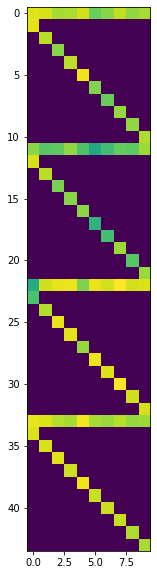

In [18]:
print(region_matrix_acc['Model'].unique())
plt.figure(figsize = (10,10))
plt.imshow(plot_df)

In [19]:
# get best model for each region for each month in test range

num_test_months = 24

best = pd.DataFrame()
for month in region_matrix_acc['Month'].unique()[:num_test_months]:
    test_df = region_matrix_acc[region_matrix_acc['Month'] == month]
    mod = []
    for col in test_df.columns[2:]:
        mod.append(test_df['Model'][test_df[col].idxmax()])
    best[month] = mod
   
        
    #     print(test_df['Model'][test_df[col].idxmax()])
best

,123,124,125,126,127,128,129,130,131,132,...,137,138,139,140,141,142,143,144,145,146
0,base_model_evap,base_model_srfexc,model_1_rzmc,model_1_rzmc,base_model_evap,base_model_evap,base_model_srfexc,base_model_srfexc,model_1_srfexc,model_1_evap,...,base_model_srfexc,model_1_rzmc,model_1_rzmc,base_model_evap,model_1_rzmc,model_1_srfexc,model_1_RainfC,base_model_evap,model_1_RainfC,model_1_rzmc
1,base_model_evap,base_model_srfexc,model_2_srfexc,model_2_rzmc,model_2_srfexc,model_2_rzmc,model_2_srfexc,model_2_rzmc,base_model_evap,base_model_srfexc,...,model_2_srfexc,model_2_srfexc,model_2_rzmc,model_2_rzmc,model_2_rzmc,model_2_rzmc,base_model_rzmc,model_2_srfexc,base_model_srfexc,base_model_srfexc
2,model_3_srfexc,model_3_srfexc,model_3_srfexc,model_3_evap,model_3_rzmc,model_3_rzmc,model_3_srfexc,model_3_srfexc,model_3_srfexc,model_3_srfexc,...,model_3_srfexc,model_3_srfexc,model_3_rzmc,model_3_rzmc,model_3_evap,model_3_srfexc,base_model_srfexc,model_3_srfexc,model_3_srfexc,model_3_srfexc
3,base_model_srfexc,model_4_srfexc,model_4_srfexc,model_4_evap,model_4_srfexc,base_model_srfexc,base_model_srfexc,base_model_srfexc,base_model_srfexc,base_model_srfexc,...,model_4_srfexc,model_4_srfexc,model_4_srfexc,model_4_srfexc,base_model_srfexc,base_model_srfexc,base_model_srfexc,base_model_srfexc,base_model_srfexc,model_4_srfexc
4,base_model_evap,base_model_srfexc,base_model_srfexc,model_5_evap,model_5_rzmc,model_5_RainfC,base_model_evap,model_5_rzmc,model_5_evap,base_model_srfexc,...,model_5_srfexc,model_5_rzmc,model_5_rzmc,model_5_RainfC,model_5_rzmc,model_5_srfexc,model_5_RainfC,model_5_evap,model_5_rzmc,model_5_evap
5,model_6_srfexc,model_6_srfexc,model_6_srfexc,model_6_evap,model_6_rzmc,model_6_rzmc,model_6_evap,model_6_rzmc,base_model_evap,base_model_srfexc,...,model_6_srfexc,model_6_rzmc,model_6_rzmc,model_6_rzmc,model_6_rzmc,model_6_rzmc,model_6_srfexc,base_model_srfexc,model_6_srfexc,model_6_srfexc
6,model_7_srfexc,model_7_srfexc,model_7_srfexc,model_7_evap,model_7_evap,model_7_rzmc,base_model_srfexc,base_model_srfexc,model_7_srfexc,model_7_srfexc,...,model_7_srfexc,model_7_rzmc,model_7_rzmc,base_model_evap,model_7_evap,model_7_srfexc,model_7_srfexc,base_model_srfexc,base_model_srfexc,model_7_srfexc
7,model_8_srfexc,model_8_srfexc,base_model_srfexc,base_model_evap,model_8_srfexc,model_8_srfexc,base_model_srfexc,base_model_srfexc,model_8_srfexc,base_model_srfexc,...,model_8_srfexc,model_8_RainfC,model_8_srfexc,model_8_RainfC,model_8_srfexc,model_8_srfexc,base_model_srfexc,base_model_srfexc,base_model_srfexc,base_model_srfexc
8,base_model_srfexc,model_9_srfexc,base_model_srfexc,model_9_rzmc,model_9_rzmc,base_model_srfexc,base_model_srfexc,base_model_srfexc,model_9_srfexc,base_model_srfexc,...,base_model_srfexc,model_9_rzmc,model_9_rzmc,model_9_rzmc,model_9_rzmc,model_9_srfexc,model_9_srfexc,base_model_srfexc,model_9_srfexc,model_9_srfexc
9,base_model_srfexc,base_model_srfexc,base_model_srfexc,model_10_srfexc,model_10_srfexc,model_10_srfexc,model_10_srfexc,model_10_srfexc,base_model_srfexc,base_model_srfexc,...,model_10_srfexc,model_10_srfexc,model_10_srfexc,model_10_srfexc,base_model_srfexc,model_10_srfexc,model_10_srfexc,base_model_srfexc,base_model_srfexc,model_10_srfexc


AttributeError: module 'pylab' has no attribute 'heatmap'

In [20]:
# get best model for each region across all test months

blueprint = []
for i in range (10):
    best_mod = (best.iloc[i].value_counts().idxmax())
    blueprint.append(best_mod)
    # print(best_mod)
blueprint

['model_1_rzmc',
 'model_2_srfexc',
 'model_3_srfexc',
 'base_model_srfexc',
 'model_5_rzmc',
 'model_6_srfexc',
 'model_7_srfexc',
 'base_model_srfexc',
 'base_model_srfexc',
 'model_10_srfexc']

In [21]:
def build(source_df, key, month):
    combined_preds = []
    for region in range(1,11):
        model_str = key[region - 1]
        col_str = str('Pred_r' + str(region))
        temp_df = source_df[(source_df['Month'] == month) & (source_df['Model'] == key[region - 1])]
        pred = temp_df[col_str].tolist()[0]
        combined_preds.append(pred)
        full_pred = np.nansum(combined_preds, axis = 0)
        full_pred[full_pred == 0] = np.nan
    return full_pred
full_pred = build(compiled_reg_split, blueprint, 123)

In [22]:
accuracy = pd.DataFrame()

# Build mixed-model output

In [23]:
start_month = 140
accuracy = pd.DataFrame()
cats = []
preds = []
full_preds = []
accs = []
accuracy['Month'] = pd.DataFrame(region_matrix_acc['Month'].unique())
export_df = accuracy.copy()
for i in accuracy['Month']:
    month = i
    full_pred = build(compiled_reg_split, blueprint, month)
    catdef = all_data_df[all_data_df['Data_month'] == month]['CA_catdef']
    catdef = np.nansum(catdef.to_list())
    acc = 1 - abs(np.nansum(full_pred) - catdef)/catdef
    cats.append(catdef)
    preds.append(np.nansum(full_pred))
    full_preds.append(full_pred)
    accs.append(acc)
export_df['predicted_catdef'] = full_preds
accuracy['catdef'] = cats
accuracy['built_model'] = preds
accuracy['acc'] = accs
accuracy = accuracy[accuracy['Month'] >= start_month]
accuracy = accuracy.reset_index(drop = True)
# export_df = accuracy[['Month', 'built_model']]
accuracy
export_df

,Month,predicted_catdef
0,123,"[nan, nan, nan, 85.938576, 103.544174, 110.915..."
1,124,"[nan, nan, nan, 130.21872, 160.34409, 169.3946..."
2,125,"[nan, nan, nan, 143.92606, 181.17183, 192.0754..."
3,126,"[nan, nan, nan, 203.37497, 250.97179, 261.5211..."
4,127,"[nan, nan, nan, 240.79918, 287.63943, 295.0433..."
5,128,"[nan, nan, nan, 227.76547, 268.82016, 275.5240..."
6,129,"[nan, nan, nan, 183.83089, 214.76942, 223.7646..."
7,130,"[nan, nan, nan, 188.42944, 219.72267, 227.1869..."
8,131,"[nan, nan, nan, 144.06348, 176.01228, 186.9007..."
9,132,"[nan, nan, nan, 148.31018, 181.59914, 189.5918..."


In [25]:
# get reference

file ='all_predictions.pkl'
# path = str('./2_input_data/' + file)
path = str('./2_input_data/' + file)


with open(path, "rb") as fh:
  ref_preds = pickle.load(fh)
ref_preds = ref_preds[ref_preds['Model'] == 'original_model']
ref_preds['masked'] = ref_preds['y_prediction'].apply(lambda x: mask_list(x, flat_mask, 9999))
ref_preds['ref_sums'] = ref_preds['masked'].apply(lambda x: np.nansum(x))
ref_preds
accuracy['original_model'] = ref_preds['ref_sums']
accuracy['orig_acc'] = 1 - abs(accuracy['catdef'] - accuracy['original_model'])/accuracy['catdef']
accuracy['improvement'] = accuracy['acc'] - accuracy['orig_acc']
accuracy

,Month,catdef,built_model,acc,original_model,orig_acc,improvement
0,140,205146.450,184597.593750,0.899833,189060.265625,0.921587,-0.021754
1,141,204609.380,188002.562500,0.918836,192214.359375,0.939421,-0.020585
2,142,201425.590,184482.484375,0.915884,183878.453125,0.912885,0.002999
3,143,166091.168,160456.968750,0.966078,142539.531250,0.858201,0.107877
4,144,179115.699,164796.125000,0.920054,153699.984375,0.858104,0.061950
5,145,172142.636,165963.937500,0.964107,148660.375000,0.863588,0.100519
6,146,172269.289,164619.921875,0.955596,147124.968750,0.854041,0.101556
7,147,178946.440,169094.187500,0.944943,154914.546875,0.865703,0.079240
8,148,181023.030,164674.265625,0.909687,161347.890625,0.891311,0.018375
9,149,184946.850,175271.312500,0.947685,169048.281250,0.914037,0.033648


In [26]:
old = np.mean(accuracy['orig_acc'])
new =  np.mean(accuracy['acc'])
print('orig: ', old*100)
print('new: ', new*100)
print('improvement: ', (new - old)*100)

orig:  88.17377906744018
new:  91.68547319288953
improvement:  3.5116941254493494


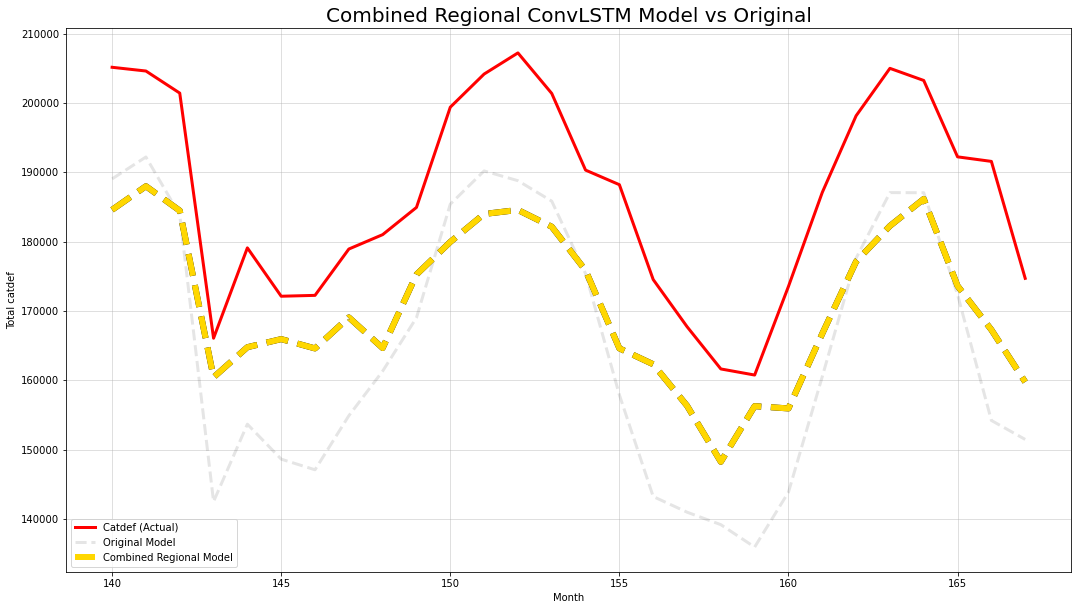

In [51]:
# accuracy.plot(x = 'Month', y = ['catdef', 'original_model'], figsize = (15, 10))
# accuracy.plot(x = 'Month', y = ['built_model'], figsize = (15, 10))
x = accuracy['Month']
y1 = accuracy['catdef']
y2 = accuracy['original_model']
y3 = accuracy['built_model']
plt.figure(figsize=(18, 10))

plt.plot(x,y1, label = 'Catdef (Actual)', c = 'red', lw = 3)
plt.plot(x,y2, label = 'Original Model', c = 'black', lw = 3, linestyle = 'dashed', alpha = .1)
plt.plot(x,y3, c = 'black', lw = 6, linestyle = 'dashed')
plt.plot(x,y3, label = 'Combined Regional Model', c = 'gold', lw = 6, linestyle = 'dashed')

plt.xlabel('Month')
plt.ylabel('Total catdef')
plt.grid(alpha = .5)
plt.title('Combined Regional ConvLSTM Model vs Original', fontsize = 20)
plt.legend()
plt.savefig('Combined Regional Model vs Original.png')
plt.show()

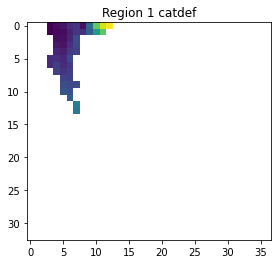

In [26]:
month = 144
combined_preds = []
for region in range(1,2):
    model_str = blueprint[region - 1]
    col_str = str('Pred_r' + str(region))
    temp_df = compiled_reg_split[(compiled_reg_split['Month'] == month) & (compiled_reg_split['Model'] == blueprint[region - 1])]
    pred = temp_df[col_str].tolist()[0]
    combined_preds.append(pred)
    full_pred = np.nansum(combined_preds, axis = 0)
    full_pred[full_pred == 0] = np.nan
    # print(col_str)
plt.title('Region 1 catdef')
plt.imshow(full_pred.reshape(33,37))

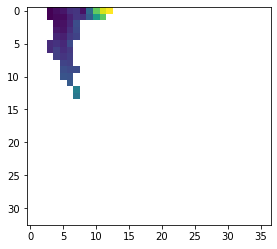

In [27]:
plt.imshow(full_pred.reshape(33,37))

In [28]:
catdef = all_data_df[all_data_df['Data_month'] == month]['CA_catdef']
catdef = np.nansum(catdef.to_list())
acc = 1 - abs(np.nansum(full_pred) - catdef)/catdef
acc

0.059993394487785845

In [29]:
export_df

,Month,predicted_catdef
0,123,"[nan, nan, nan, 85.938576, 103.544174, 110.915..."
1,124,"[nan, nan, nan, 130.21872, 160.34409, 169.3946..."
2,125,"[nan, nan, nan, 143.92606, 181.17183, 192.0754..."
3,126,"[nan, nan, nan, 203.37497, 250.97179, 261.5211..."
4,127,"[nan, nan, nan, 240.79918, 287.63943, 295.0433..."
5,128,"[nan, nan, nan, 227.76547, 268.82016, 275.5240..."
6,129,"[nan, nan, nan, 183.83089, 214.76942, 223.7646..."
7,130,"[nan, nan, nan, 188.42944, 219.72267, 227.1869..."
8,131,"[nan, nan, nan, 144.06348, 176.01228, 186.9007..."
9,132,"[nan, nan, nan, 148.31018, 181.59914, 189.5918..."


In [30]:
#### save compiled pred to .pkl

compile_predictions = 1
if compile_predictions == 1:
    path = './out_to_ensemble/convlstm_predictions.pkl'
    with open(path, "wb") as fh:
        pickle.dump(export_df, fh)

In [31]:
all_data_df

,Year,Data_month,SCA,Landsat_Image,BW_SCA_Image,Color_SCA_Image,CA_catdef,catdef,catdef_region_1,catdef_region_2,...,sfmc,capac,Snowf,Rainf,prmc,sumwesn,runoff,Tair,RainfC,rzmc
0,2003,0,294585,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 38.347, 58.863, 72.956, 104.4...","[[nan, nan, nan, 38.347, 58.863, 72.956, 104.4...","[[nan, nan, nan, 38.347, 58.863, 72.956, 104.4...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",...,"[[nan, nan, nan, 0.45009, 0.41456000000000004,...","[[nan, nan, nan, 0.07147200000000001, 0.069579...","[[nan, nan, nan, 0.0, 4.0366999999999995e-05, ...","[[nan, nan, nan, 9.8164, 9.1992, 7.3516, 5.421...","[[nan, nan, nan, 0.46491000000000005, 0.42658,...","[[nan, nan, nan, 1.9386e-05, 0.00053811, 0.009...","[[nan, nan, nan, 7.8125, 7.9023, 6.6211, 3.629...","[[nan, nan, nan, 284.14, 283.06, 281.55, 281.1...","[[nan, nan, nan, 0.12506, 0.12585, 0.10165, 0....","[[nan, nan, nan, 0.47278000000000003, 0.442019..."
1,2003,1,19185627,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 54.951, 79.32600000000001, 90...","[[nan, nan, nan, 54.951, 79.32600000000001, 90...","[[nan, nan, nan, 54.951, 79.32600000000001, 90...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",...,"[[nan, nan, nan, 0.43295, 0.39828, 0.36313, 0....","[[nan, nan, nan, 0.067444, 0.10471, 0.092987, ...","[[nan, nan, nan, 0.027298000000000003, 0.04013...","[[nan, nan, nan, 4.377, 4.3574, 3.7314, 2.8877...","[[nan, nan, nan, 0.45143, 0.40968999999999994,...","[[nan, nan, nan, 0.0026054000000000003, 0.0053...","[[nan, nan, nan, 3.4277, 3.8438, 3.5537, 2.386...","[[nan, nan, nan, 281.02, 279.66, 278.21, 278.1...","[[nan, nan, nan, 0.35803, 0.32971, 0.230590000...","[[nan, nan, nan, 0.45508000000000004, 0.42786,..."
2,2003,2,39522095,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 58.096000000000004, 80.846, 9...","[[nan, nan, nan, 58.096000000000004, 80.846, 9...","[[nan, nan, nan, 58.096000000000004, 80.846, 9...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",...,"[[nan, nan, nan, 0.43599, 0.40242, 0.365309999...","[[nan, nan, nan, 0.059937, 0.09848, 0.10797000...","[[nan, nan, nan, 0.00029898, 0.001753300000000...","[[nan, nan, nan, 8.875, 8.3047, 6.4688, 5.0547...","[[nan, nan, nan, 0.45028, 0.40975, 0.3652, 0.3...","[[nan, nan, nan, 1.5571999999999999e-06, 9.130...","[[nan, nan, nan, 5.7129, 5.6113, 4.375, 2.9229...","[[nan, nan, nan, 282.26, 281.13, 279.84, 279.9...","[[nan, nan, nan, 0.31006, 0.2572, 0.17047, 0.1...","[[nan, nan, nan, 0.4537, 0.42867, 0.38632, 0.3..."
3,2003,3,53739475,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 50.902, 74.34, 89.059, 98.902...","[[nan, nan, nan, 50.902, 74.34, 89.059, 98.902...","[[nan, nan, nan, 50.902, 74.34, 89.059, 98.902...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",...,"[[nan, nan, nan, 0.44292, 0.40849, 0.3726, 0.3...","[[nan, nan, nan, 0.079956, 0.12982, 0.19555999...","[[nan, nan, nan, 0.38354, 0.65161, 0.88013, 0....","[[nan, nan, nan, 8.6953, 8.5234, 7.334, 6.5078...","[[nan, nan, nan, 0.45588, 0.41511000000000003,...","[[nan, nan, nan, 0.074188, 0.14722000000000002...","[[nan, nan, nan, 6.0234, 6.3164, 5.4961, 4.298...","[[nan, nan, nan, 280.85, 279.66, 278.47, 278.7...","[[nan, nan, nan, 0.68433, 0.58594, 0.42126, 0....","[[nan, nan, nan, 0.46101000000000003, 0.43318,..."
4,2003,4,46363941,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 77.083, 103.3, 112.11, 113.8,...","[[na

********************